In [58]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import numpy as np
import numpy.matlib as matlib
import glob
import re
import os
import tensorflow as tf
import sys
sess = tf.InteractiveSession()

In [68]:
def downsampleByTwo(img):
        tmp = np.array(img)
        # if the number of rows is odd, pad with a row of zeros
        if (tmp.shape[0] & 0x01):
            tmp = np.vstack([tmp, np.zeros((1, tmp.shape[1]))])

        if (tmp.shape[1] & 0x01):
            tmp = np.hstack([tmp, np.zeros((tmp.shape[0], 1))])

        ret = np.zeros(np.array(tmp.shape) / 2)

        for i in range(tmp.shape[0]):
            for j in range(tmp.shape[1]):
                ret[i/2,j/2] = .25 * tmp[i,j]

        return ret

def preprocessImage(img):
    edges = ndimage.filters.sobel(img)
    opening = ndimage.morphology.binary_opening(edges, structure=np.ones((2,2)))
    ds = downsampleByTwo(opening)
    ds = downsampleByTwo(ds)
    ds = downsampleByTwo(ds)
    return ds

if not os.path.exists('trainingData.p'):
    train = pd.read_csv('data/train.csv', index_col=0, dtype='object')

    trainData = []

    marginCols = ['margin{0}'.format(i) for i in range(1, 65)]
    textureCols = ['texture{0}'.format(i) for i in range(1, 65)]
    shapeCols = ['shape{0}'.format(i) for i in range(1, 65)]

    ## Generate one hot encoding for species
    classNames = sorted(np.unique(train['species']))
    numClasses = len(classNames)
    labelMap = {k:i for i,k in enumerate(classNames)}

    

    columnGroups = [marginCols, textureCols, shapeCols]
    for r in train.iterrows():
        caseId = r[0]
        print '\r','{0:4d}'.format(caseId),
        sys.stdout.flush()
        trainData.append([caseId])
        # Generate one hot encoding for species
        oneHot = np.zeros((numClasses,))
        oneHot[labelMap[r[1]['species']]] = 1.0
        classId = labelMap[r[1]['species']]
        trainData[-1].append(classId)
        trainData[-1].append(oneHot)

        for col in columnGroups:
            curr = r[1][col]
            trainData[-1].append(np.array(curr))

        img = ndimage.imread('data/images/{0}.jpg'.format(caseId)) / 255.0
        img = preprocessImage(img)
        img = np.expand_dims(img, -1)
        trainData[-1].append(img)
        trainData[-1].append(img.shape[0])
        trainData[-1].append(img.shape[1])
    trainData = pd.DataFrame(trainData, columns=['caseId', 'classId', 'oneHot', 'margin', 
                                                 'textureCols', 'shape',
                                                 'img', 'height', 
                                                 'width'])
    pd.to_pickle(trainData, 'trainingData.p')
else:
    trainData = pd.read_pickle('trainingData.p')
    
class LeafData:
    '''
    Takes in a dataframe of samples
    '''
    def __init__(self, data, testSplit, numClasses=None):
        if numClasses:
            self.numClasses = numClasses
        else:
            self.numClasses = np.max(data.iloc[0]['oneHot'].shape)
            
        data = data[data['classId'] < self.numClasses]
        
        numItems = len(data)
        numTestItems = int(numItems * testSplit)
        testSelector = np.random.choice(numItems, numTestItems,
                                        replace=False)
        self._testCases = data.iloc[testSelector].copy(deep=True)
        trainCaseSelector = list(set(range(numItems)) - set(testSelector))
        self._trainCases = data.iloc[trainCaseSelector].copy(deep=True)
                
        self._trainIndex = 0
        
        self._maxWidth = np.max(data['width'])
        self._maxHeight = np.max(data['height'])

        # Define the height as around twice the max image height/width
        # but make sure it's divisible by 4
        self.normImgWidth = 128
        self.normImgHeight = 128

        
    
    def getTrainBatch(self, n):
        y = np.zeros((n, self.numClasses))
        img = np.zeros((n, self.normImgHeight, self.normImgWidth, 1))
        
        for i in range(n):
            currCase = self._trainCases.iloc[self._trainIndex]
            currImg = np.squeeze(currCase['img'])
            rot = np.random.random(1) * 360
            currImg = ndimage.rotate(currImg, rot)
            imgHeight = currImg.shape[0]
            imgWidth = currImg.shape[1]
            currImg = np.expand_dims(currImg, -1)

            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim, 1))
            
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currImg
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim, 1)
            img[i, :, :, :] = ndimage.zoom(tmpImg, targetSize)

            y[i, :] = currCase['oneHot'][:self.numClasses]
            self._trainIndex += 1
            
            if self._trainIndex == len(self._trainCases):
                self._trainIndex = 0
                self._trainCases = self._trainCases.sample(frac=1.0)
        return img, y
    
    def getTestData(self):
        y = np.zeros((len(self._testCases), self.numClasses))
        img = np.zeros((len(self._testCases), self.normImgHeight, self.normImgWidth, 1))
        for i in range(len(self._testCases)):
            currCase = self._trainCases.iloc[self._trainIndex]
            imgHeight = currCase['height']
            imgWidth = currCase['width']
            
            maxDim = np.max([imgHeight, imgWidth])
            tmpImg = np.zeros((maxDim, maxDim, 1))
            lrShift = (maxDim - imgWidth) / 2
            udShift = (maxDim - imgHeight) / 2
            tmpImg[udShift:udShift+imgHeight, lrShift:lrShift+imgWidth] = currCase['img']
            
            targetSize = (float(self.normImgHeight) / maxDim, float(self.normImgWidth) / maxDim, 1)
            img[i, :, :, :] = ndimage.zoom(tmpImg, targetSize)

            y[i, :] = currCase['oneHot'][:self.numClasses]
            self._trainIndex += 1
        return img, y
        
        
data = LeafData(trainData, .3, numClasses=2)


In [ ]:
data._trainCases

<IPython.core.display.Javascript object>


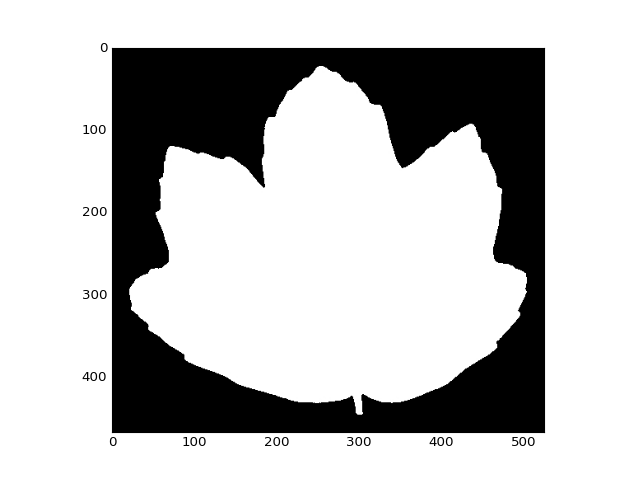

<IPython.core.display.Javascript object>


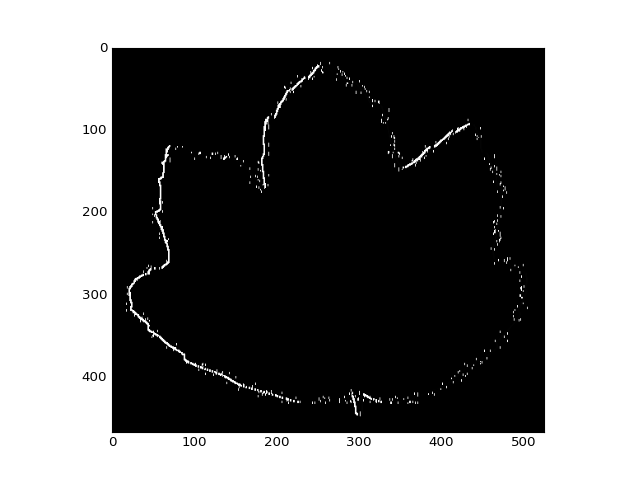

<IPython.core.display.Javascript object>


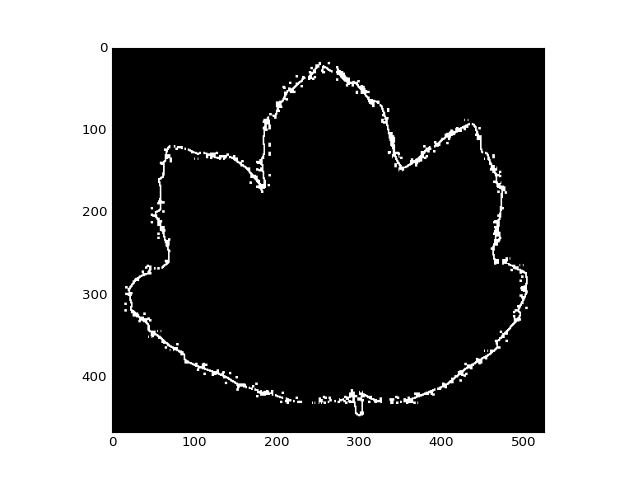

In [52]:
img = ndimage.imread('data/images/1.jpg')

plt.figure()
plt.imshow(img, cmap='gray')

edges = ndimage.filters.sobel(img)
plt.figure()
plt.imshow(edges, cmap='gray')

opening = ndimage.morphology.binary_closing(edges, structure=np.ones((2,2)))
plt.figure()
plt.imshow(opening, cmap='gray')



<IPython.core.display.Javascript object>


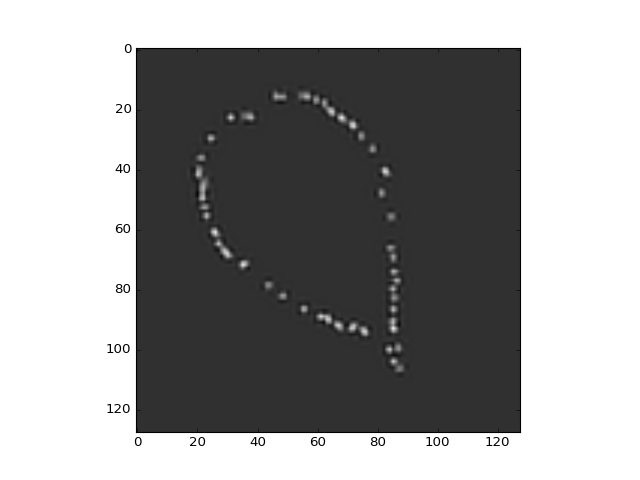

In [71]:
plt.figure()
img, label = data.getTrainBatch(1)
plt.imshow(np.squeeze(img), cmap='gray')

In [77]:

learningRate = 1e-6

print 'Defining Graph'

def weight_variable(shape, name=None): 
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name=None):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, name=None):
    print 'Conv2D x', x
    print 'Conv2D W', W
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    print 'Max_pool x', x
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME', name=name)

def convLayer(x, w, b, name=None):
    conv = tf.nn.relu(conv2d(x, w, name=name+'_conv2d') + b, name=name+'_relu')
    pool = max_pool_2x2(conv, name=name+'_maxPool')
    print 'convLayer pool', pool
    return pool

x = tf.placeholder(tf.float32, shape=[None, data.normImgHeight, data.normImgWidth, 1], name='imgPlaceHolder')
labels = tf.placeholder(tf.float32, shape=[None, data.numClasses], name='labelPlaceHolder')

## Layer definitions
# Layer 1 - Convolutional
kernelSize = 5
numOutputs = 32
numInputChannels = 1
W_conv1 = weight_variable([kernelSize, kernelSize, 
                           numInputChannels, numOutputs], name='w_conv1')
b_conv1 = bias_variable([numOutputs], name='b_conv1')

pool1 = convLayer(x, W_conv1, b_conv1, name='pool1')

outputWidth = data.normImgWidth / 2
outputHeight = data.normImgHeight / 2

# Layer 2 - Convolutional
kernelSize = 7
numInputChannels = numOutputs
numOutputs = 32

W_conv2 = weight_variable([kernelSize, kernelSize,
                           numInputChannels, numOutputs], name='w_conv2')
b_conv2 = bias_variable([numOutputs], name='b_conv2')

pool2 = convLayer(pool1, W_conv2, b_conv2, name='pool2')

outputWidth = outputWidth / 2
outputHeight = outputHeight / 2

# # Layer 3 - Convolutional
# kernelSize = 7
# numInputChannels = numOutputs
# numOutputs = 32

# W_conv3 = weight_variable([kernelSize, kernelSize,
#                            numInputChannels, numOutputs], name='w_conv3')
# b_conv3 = bias_variable([numOutputs], name='b_conv3')

# pool3 = convLayer(pool2, W_conv3, b_conv3, name='pool3')

# outputWidth = outputWidth / 2
# outputHeight = outputHeight / 2

# # # Layer 4 - Convolutional
# kernelSize = 3
# numInputChannels = numOutputs
# numOutputs = 32

# W_conv4 = weight_variable([kernelSize, kernelSize,
#                            numInputChannels, numOutputs], name='w_conv4')
# b_conv4 = bias_variable([numOutputs], name='b_conv4')

# pool4 = convLayer(pool3, W_conv4, b_conv4, name='pool4')

# outputWidth = outputWidth / 2
# outputHeight = outputHeight / 2


# Layer 4 - Fully connected
fcNeurons = 1024
print outputWidth, outputHeight
W_fc1 = weight_variable([outputWidth * outputHeight * numOutputs, fcNeurons], name='w_fc1')
b_fc1 = bias_variable([fcNeurons], name='b_fc1')

pool2_flat = tf.reshape(pool2, [-1, outputWidth * outputHeight * numOutputs], name='flatten')
fc1 = tf.nn.relu(tf.matmul(pool2_flat, W_fc1, name='fc1_matmul') + b_fc1, name='fc1_relu')
print 'Pool2', pool2
print 'Pool2_flat', pool2_flat, outputWidth, outputHeight, numOutputs


# # Layer 4 - Fully connected
# fcNeurons = 512
# print outputWidth, outputHeight
# W_fc2 = weight_variable([outputWidth * outputHeight * numOutputs, fcNeurons], name='w_fc2')
# b_fc2 = bias_variable([fcNeurons], name='b_fc2')

# fc2 = tf.nn.relu(tf.matmul(fc1, W_fc2, name='fc2_matmul') + b_fc2, name='fc2_relu')

# Layer 4 - Dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
dropout = tf.nn.dropout(fc1, keep_prob, name='dropoutLayer')

# Layer 5 - Readout
W_fc2 = weight_variable([fcNeurons, data.numClasses], name='w_fc2')
b_fc2 = bias_variable([data.numClasses], name='b_fc2')
y_conv = tf.matmul(dropout, W_fc2, name='y_conv') + b_fc2



# Define loss function
print 'Defining Loss Function'
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=labels, name='sm_cewl'))
train_step = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print 'Initializing Vars'
sess.run(tf.global_variables_initializer())

def softmax(w):
    w = np.array(w)

    maxes = np.amax(w, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(w - maxes)
    summed = np.sum(e, axis=1)
    div = np.vstack([summed] * w.shape[1]).T
    dist = e / div
    return dist
    
fig = plt.figure()
print 'Starting Learning'
for i in range(1000):
    img, y = data.getTrainBatch(9)
    
    if i % 10 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: img,
            labels: y,
            keep_prob: 1.0
        })
        
        xentropy = cross_entropy.eval(feed_dict={
            x: img,
            labels: y,
            keep_prob: 1.0
        })
        print ('Step: {0} Training Accuracy: {1} Entropy: {2}'.format(i, train_accuracy, xentropy))
        guessedLabels = y_conv.eval(feed_dict={
            x: img,
            labels: y,
            keep_prob: 1.0
        })
        print 'Logits\r\n', np.hstack([softmax(guessedLabels), y])
        plt.figure(fig.number)
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(np.squeeze(img[i, :, :]), cmap='gray')
        fig.canvas.draw()
    train_step.run(feed_dict={
        x: img,
        labels: y,
        keep_prob: 1.0
    })


Defining Graph
Conv2D x Tensor("imgPlaceHolder_11:0", shape=(?, 128, 128, 1), dtype=float32)
Conv2D W Tensor("w_conv1_11/read:0", shape=(5, 5, 1, 32), dtype=float32)
Max_pool x Tensor("pool1_relu_11:0", shape=(?, 128, 128, 32), dtype=float32)
convLayer pool Tensor("pool1_maxPool_11:0", shape=(?, 64, 64, 32), dtype=float32)
Conv2D x Tensor("pool1_maxPool_11:0", shape=(?, 64, 64, 32), dtype=float32)
Conv2D W Tensor("w_conv2_1/read:0", shape=(7, 7, 32, 32), dtype=float32)
Max_pool x Tensor("pool2_relu_1:0", shape=(?, 64, 64, 32), dtype=float32)
convLayer pool Tensor("pool2_maxPool_1:0", shape=(?, 32, 32, 32), dtype=float32)
32 32
Pool2 Tensor("pool2_maxPool_1:0", shape=(?, 32, 32, 32), dtype=float32)
Pool2_flat Tensor("flatten_11:0", shape=(?, 32768), dtype=float32) 32 32 32
Defining Loss Function
Initializing Vars


KeyboardInterrupt: 

In [ ]:
272 * 408 * 32 * 2

In [ ]:
np.max(trainData.iloc[0]['oneHot'].shape)

In [ ]:
a = np.array([1,2,3])

In [ ]:
a.shape

In [ ]:
np.expand_dims(a, 0).shape

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(tf.get_default_graph().as_graph_def())